<a href="https://colab.research.google.com/github/onmax/bike-forecasting/blob/main/src/models/one_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/onmax/bike-forecasting/
%cd bike-forecasting/src/models

In [ ]:
!pip3 install tensorflow keras livelossplot tensorboard pandas >> /dev/null

In [8]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Reshape

import sys

sys.path.insert(1, '../../preprocessing/')
sys.path.insert(1, '../../graphs/')
sys.path.insert(1, '..')
from window import WindowGenerator
from model_lib import compile_and_fit
from dataset_lib import load_dataset, split_dataset
from lr import lr_timeline
from predictions import plot_predictions


In [11]:
df = load_dataset("/..")

Putting together /mnt/f/proyectos/bikes/src/models/recurrent/../../../data/files/../parts/chicago-divvy-trips-part-1
Putting together /mnt/f/proyectos/bikes/src/models/recurrent/../../../data/files/../parts/chicago-divvy-trips-part-2
Putting together /mnt/f/proyectos/bikes/src/models/recurrent/../../../data/files/../parts/chicago-divvy-trips-part-3


In [12]:
train_df, val_df = split_dataset(df, train_from=datetime(2018, 1, 1))
num_features = train_df.shape[1]

Training from 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Validating from 2019-01-01 00:00:00 to 2019-12-31 23:00:00


In [13]:
train_df

,quantity_1,quantity_100,quantity_101,quantity_102,quantity_103,quantity_106,quantity_107,quantity_108,quantity_109,quantity_11,...,quantity_93,quantity_94,quantity_95,quantity_96,quantity_97,quantity_98,quantity_99,hour,day_of_week,month
start_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,1
2018-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1,1,1
2018-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,1
2018-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,1
2018-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,19,1,12
2018-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1,12
2018-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,1,12


In [14]:
OUT_STEPS = 1
window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df, val_df=val_df)

In [ ]:
model = tf.keras.Sequential([
    SimpleRNN(100, return_sequences=True),
    SimpleRNN(100),
    Dense(1)
])
history = compile_and_fit(model, window, should_stop=True, max_epochs=100, with_lr_schedule=True)

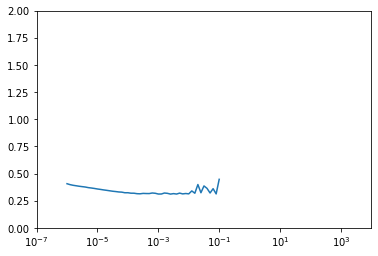

In [39]:
lr_timeline(history, [1e-7, 1e4, 0, 2]) 

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    SimpleRNN(100, return_sequences=True),
    SimpleRNN(100),
    Dropout(0.2),
    Dense(633)
])
history = compile_and_fit(model, window, lr=0.001, should_stop=False, max_epochs=100, tensorboard=True)

In [13]:
plot_predictions(window, model, 10)

ValueError: x and y must be the same size